## Analysis on Daily Global Weather Dataset

This notebook contains the analysis performed on the daily global weather dataset. The following sections go through the data science lifecycle and raise intersting discoveries. Before we dive into detail, we first import the necessary libraries.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# import sys
# !{sys.executable} -m pip install reverse_geocoder

import numpy as np
import pandas as pd
import seaborn as sns
import reverse_geocoder as rg
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

## Data Sampling and Collection

In this section, we illustrate the process to collect the data and discuss interesting findings.

__Q: How were the data collected?__

The dataset on daily global weather for year 2020 is collected from the National Centers for Environmental Information (NCEI)'s Global Historical Climatorlogy Network (GHCN) Daily database, which contains daily climate reports from land surface stations across the globe. It is a huge dataset with records from over 100,000 stations in 180 countries over the years. The GHCN database receives daily updates from a variety of data streams, which also undergo a suite of quality checks [1]. GHCN also has proper method to regularly sync up with the growing list of constituent sources [1]. Given that the dataset we use is from 2020, we believe there will not be syncing issues or dataset update issues, as we are already in April 2021.

To better fit with our project, the course staff has preprocessed the year 2020 GHCN-Daily dataset to include only the average temperature and precipitation measurements from stations that have both measurements. Now, each row in the processed dataset contains both the average temperature and precipitation measurements for a given station on a given date in 2020.

To sum up, the dataset is collected from GHCN-Daily year 2020 database. Then, we apply preprocessing to contain only entries that report both average temperature and precipitation for a given station on a given date.

__Q: Was there any potential bias introduced in the sampling process?__

The GHCN Daily database receives daily updates from its list of "subscribers", i.e., it receives data from registered stations across the globe. Hence, there may exist selection bias, because stations that do not work with the NCEI will not submit their data to the GHCN database, and so causing the GHCN database to miss such information. Even though GHCN is constantly updating the list of stations it receives from, there could always exist stations that don't submit data to GHCN.

## Data Cleaning

We inspect the dataset and perform data cleaning. Then, we discuss the findings. We start by loading the dataset.

In [2]:
daily_global_weather = pd.read_csv("../data/daily_global_weather_2020.csv")
daily_global_weather.head()

,Unnamed: 0,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,0,AE000041196,2020-01-01,211.0,25.333,55.5170,34.0,0.0
1,1,AEM00041194,2020-01-01,217.0,25.255,55.3640,10.4,0.0
2,2,AFM00040938,2020-01-01,54.0,34.210,62.2280,977.2,23.0
3,3,AG000060611,2020-01-01,71.0,28.050,9.6331,561.0,10.0
4,4,AGE00147708,2020-01-01,99.0,36.720,4.0500,222.0,0.0


We noticed that the "Unnamed: 0" column represents the index, so it is redundant. We simply drop this column.

In [3]:
print(daily_global_weather["Unnamed: 0"].unique() == daily_global_weather.index.to_list())
daily_global_weather_new = daily_global_weather.drop(columns=["Unnamed: 0"])
daily_global_weather_new.head()

[ True  True  True ...  True  True  True]


,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,AE000041196,2020-01-01,211.0,25.333,55.5170,34.0,0.0
1,AEM00041194,2020-01-01,217.0,25.255,55.3640,10.4,0.0
2,AFM00040938,2020-01-01,54.0,34.210,62.2280,977.2,23.0
3,AG000060611,2020-01-01,71.0,28.050,9.6331,561.0,10.0
4,AGE00147708,2020-01-01,99.0,36.720,4.0500,222.0,0.0


Now we narrow down to entries of station reports in US, because we plan to conduct research questions primarily in US region with the use of several datasets.

In [4]:
daily_global_weather_US = daily_global_weather_new[daily_global_weather_new["Station"].str[0:2] == "US"]
daily_global_weather_US.head()

,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
2542,USS0003E03S,2020-01-01,-8.0,44.11,-103.98,2100.1,51.0
2543,USS0003E05S,2020-01-01,15.0,44.21,-103.79,1868.4,25.0
2544,USS0004E07S,2020-01-01,14.0,44.49,-104.41,1801.4,51.0
2545,USS0005G04S,2020-01-01,-49.0,42.44,-105.86,2552.7,25.0
2546,USS0005G05S,2020-01-01,-42.0,42.28,-105.58,2407.9,0.0


__Q: What type of data are you exploring?__

At this point, we can say that we are exploring numerical data in this dataset. 

- "Station" is a qualitative nominal variable that represents a station in the US that reports weather info.
- "Date" encodes time-series information on when the weather info is reported. We may convert this column to datetime objects.
- "TAVG" is a quantitative continuous variable that encodes the average temperature in tenths of C.
- "Lattitude" and "Longtitude" are qualitative nominal variables that encode geographical location of the station.
- "Elevation" is a quantitative continuous variable that encodes the height of station with respect to sea level.
- "RPCP" is a quantitative continuous variable that encodes the average precipitation in tenths of MM.

__Q: What is the granularity of the data?__

Each row represents a weather report (the average temperature and precipitation) at a given station in US at a given date between 2020-01-01 to 2020-10-22. (This granularity is attained from the below analysis).

We then convert the data to the desired form and check for outliers in each column.

In [5]:
# TAVG is recorded as average temperature in tenths od degrees in C
# to properly retrieve the temperature in C, we divide by 10
daily_global_weather_US.loc[:, "TEMP_C"] = daily_global_weather_US.loc[:, "TAVG"] / 10.0
# the temperature range is valid according to [2], so no outliers in this column
print("Temp in C:")
print(daily_global_weather_US["TEMP_C"].describe())
print()

# Date captures the date of the measurement
daily_global_weather_US["Datetime"] = pd.to_datetime(daily_global_weather_US["Date"], format="%Y-%m-%d")
# the date range is valid, but we miss values after Oct-22, 2020. The 296 unique values suggest we have good
# coverage within the month from Jan to Oct.
print("Date in datetime format:")
print(daily_global_weather_US["Datetime"].describe())
print()

# Lattitude and Longitude captures the geographical location of a given station
# According to [3], these values are also legit.
print("Latitude:")
print(daily_global_weather_US["Latitude"].describe())
print()
print("Longitude:")
print(daily_global_weather_US["Longitude"].describe())
print()

# Elevation captures the height above the sea-level of the given measurement station
# We see extreme values in this column, but we will keep it for now as they may represent
# stations that are just high inside the mountains and etc.
print("Elevation:")
print(daily_global_weather_US["Elevation"].describe())
print()

# PRCP captures the average precipitation in tenths of millimeters
# to properly retrieve the precipitation in millimeters, we divide by 10
# According to [4], it seems like the max 419.1 is not an outlier
daily_global_weather_US.loc[:, "PRCP_Millimeter"] = daily_global_weather_US.loc[:, "PRCP"] / 10.0
print("PRCP_Millimeter:")
print(daily_global_weather_US["PRCP_Millimeter"].describe())
print()

Temp in C:
count    304466.000000
mean          8.378097
std          10.113867
min         -48.300000
25%           1.200000
50%           8.900000
75%          15.400000
max          40.800000
Name: TEMP_C, dtype: float64

Date in datetime format:
count                  304466
unique                    296
top       2020-04-25 00:00:00
freq                     1047
first     2020-01-01 00:00:00
last      2020-10-22 00:00:00
Name: Datetime, dtype: object

Latitude:
count    304466.000000
mean         42.805657
std           7.064853
min          19.719200
25%          38.990000
50%          42.360600
75%          45.500000
max          71.283300
Name: Latitude, dtype: float64

Longitude:
count    304466.000000
mean       -111.235003
std          16.121753
min        -170.222200
25%        -118.690000
50%        -111.490000
75%        -106.160000
max         -68.017200
Name: Longitude, dtype: float64

Elevation:
count    304466.000000
mean       1665.902292
std        1063.634190
min  

Based on above analysis, there are no outliers in this dataset. Here, we use external sources to reasonably gauge if the values in a column is normal. For example, we checked the largest amount of rainfall in US in 24-hour and found 1262.126 millimeters as one example. Compared to that, 419.1 seems reasonable. So, this dataset does not contain outliers.

In [6]:
# after preliminary analysis, we only keep the Station, Latitude, Longtitide, Elevation, TEMP_C,
# Datetime, PRCP_Millimeter
daily_global_weather_US_final = daily_global_weather_US[["Station", "Latitude", "Longitude",
                                                  "Elevation", "TEMP_C", "Datetime",
                                                  "PRCP_Millimeter"]]
daily_global_weather_US_final.head()

,Station,Latitude,Longitude,Elevation,TEMP_C,Datetime,PRCP_Millimeter
2542,USS0003E03S,44.11,-103.98,2100.1,-0.8,2020-01-01,5.1
2543,USS0003E05S,44.21,-103.79,1868.4,1.5,2020-01-01,2.5
2544,USS0004E07S,44.49,-104.41,1801.4,1.4,2020-01-01,5.1
2545,USS0005G04S,42.44,-105.86,2552.7,-4.9,2020-01-01,2.5
2546,USS0005G05S,42.28,-105.58,2407.9,-4.2,2020-01-01,0.0


Now we check if the dataset has missing values.

In [7]:
print(daily_global_weather_US_final.isnull().sum())

Station            0
Latitude           0
Longitude          0
Elevation          0
TEMP_C             0
Datetime           0
PRCP_Millimeter    0
dtype: int64


__Q: Are there missing value or invalid entries in the dataset?__

By the above analysis, this dataset does not contain any missing value or invalid entries.

We get a better sense of the distribution of data through plotting.

In [8]:
# define a plotting function to visualize distribution
def visualize_uni_distribution(df, name, ax, trans=None):
    if trans is None:
        sns.distplot(df[name], ax=ax)
    elif trans == "log":
        eps = 1e-10
        sns.distplot(np.log10(df[name] + eps), ax=ax)

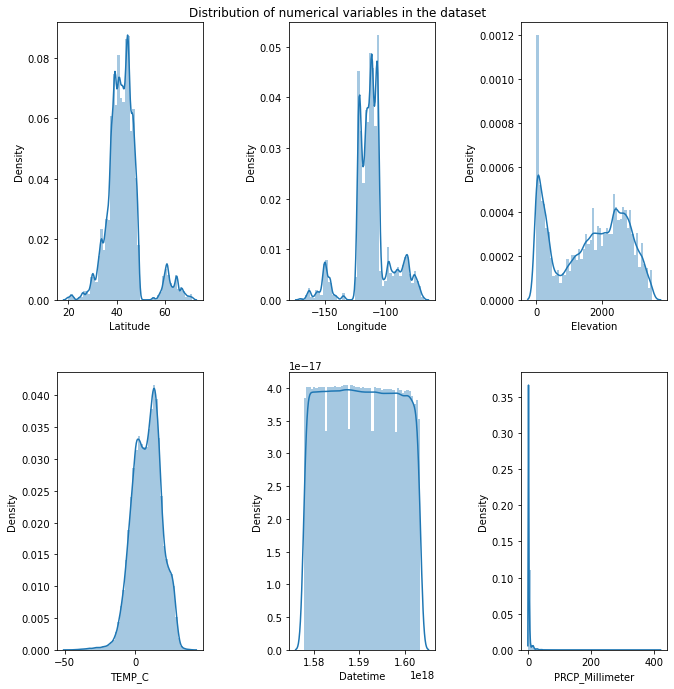

In [9]:
# we see the distribution for each variable (except station)
fig, axs = plt.subplots(2, 3, figsize=(10,10))
i, j = 0, 0

for var in daily_global_weather_US_final.columns.to_list():
    if var == "Station":
        continue
    visualize_uni_distribution(daily_global_weather_US, var, axs[i, j])
    if j == 2:
        i += 1
        j = 0
    else:
        j += 1

fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of numerical variables in the dataset");

__Q: What does the distribution of the data looks like?__

__Latitude:__
This data is bimodal. The majority of latitude exists between 30 and 50, roughly speaking. 

__Longitude:__
This data is multimodal. The majority of longitude exists between -125 and -100, roughly speaking.

__Elevation:__
This data is bimodal. The majority of elevation exists between 0-500 and 2000-3000, roughly speaking. 

__TEMP_C:__
This data is bimodal. The majority of temperature exists between -10 and 30, roughly speaking.

__Datetime:__
This data is pretty uniform, with 4 troughs between 2020-01-01 and 2020-10-22. The visulization suggests that we have good coverage of data across Jan 2020 to Oct 2020. We may further inspect the date of the four troughs. Could these four days be the days where the database gets maintainance?

__PRCP_Millimeter:__
This data is unimodal, and it is heavily right skewed (It has a long tail to the right). However, from above analysis, we can't say the measurement is an outlier, because the maximum 419.1 is still reasonable in nature for precipitation. To better visulize this distribution, we apply a log transformation, as shown below. After log transformation, we see the data is bimodal. This suggests that we have two clusters of pricipitation in the dataset, one around $0$, the other around $10^{0.5}$.

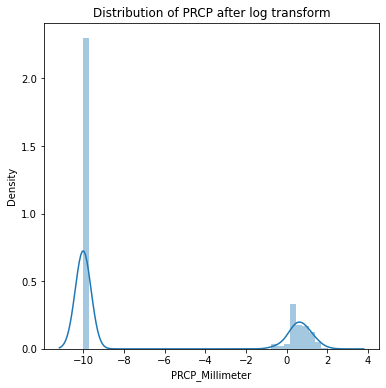

In [10]:
fig_1, ax_1 = plt.subplots(1, 1, figsize=(6,6))
visualize_uni_distribution(daily_global_weather_US, "PRCP_Millimeter", ax_1, trans="log")
ax_1.set_title("Distribution of PRCP after log transform");

From above visulizations and analysis, we can see that we have uniformly distributed data from each day between 2020-01-01 to 2020-10-22. 

Then, if we look at temperature, we can see that the data has tiny percentage of values to both ends, and the curve is a little bit left skewed, but we can still fit a normal distribution to it. This suggests that the temperature data is pretty good, as the majority of them is near the mean and we don't have too many extreme values. 

Then, if we look at precipitation, we cann see that the data is heavily right skewed. The log transformation then indicates that we have a great amount of data in the $0$ and $10^{0.5}$ place. This visulization suggests that we tend to observe little rainfall or a small amount of rainfall. We are very unlikely to see large rainfalls.

The visulization on latitude and longitude may later be used to determine what are the popular places for these stations, i.e., what are the states or geographical locations that have a lot of such stations.

The visulization of elevation may not be used in the later analysis, so we ignore it for now.

## Exploratory Data Analysis

In this section, we explore the relationship between variables and getting to know more about the data.

In [33]:
# we make it more fine grained
daily_global_weather_US_final["year"] = daily_global_weather_US_final["Datetime"].dt.year
daily_global_weather_US_final["month"] = daily_global_weather_US_final["Datetime"].dt.month
daily_global_weather_US_final["week"] = daily_global_weather_US_final["Datetime"].dt.week
daily_global_weather_US_final["day"] = daily_global_weather_US_final["Datetime"].dt.day

daily_global_weather_US_final.head()

,Station,Latitude,Longitude,Elevation,TEMP_C,Datetime,PRCP_Millimeter,year,month,day,geo_cord,state,county,week
2542,USS0003E03S,44.11,-103.98,2100.1,-0.8,2020-01-01,5.1,2020,1,1,"(44.11, -103.98)",South Dakota,Lawrence County,1
2543,USS0003E05S,44.21,-103.79,1868.4,1.5,2020-01-01,2.5,2020,1,1,"(44.21, -103.79)",South Dakota,Lawrence County,1
2544,USS0004E07S,44.49,-104.41,1801.4,1.4,2020-01-01,5.1,2020,1,1,"(44.49, -104.41)",Wyoming,Crook County,1
2545,USS0005G04S,42.44,-105.86,2552.7,-4.9,2020-01-01,2.5,2020,1,1,"(42.44, -105.86)",Wyoming,Converse County,1
2546,USS0005G05S,42.28,-105.58,2407.9,-4.2,2020-01-01,0.0,2020,1,1,"(42.28, -105.58)",Wyoming,Converse County,1


We trace the geographical location back to its county and state, and we include columns in the resulting dataframe.

In [34]:
# extract the coordinates
daily_global_weather_US_final["geo_cord"] = list(daily_global_weather_US_final[['Latitude', 'Longitude']].itertuples(index=False, name=None))
# use rg to search
res = rg.search(daily_global_weather_US_final["geo_cord"].to_list())

states, county = [], []
for i in res:
    states.append(i["admin1"])
    county.append(i["admin2"])
    
# keep track of the information
daily_global_weather_US_final["state"] = states
daily_global_weather_US_final["county"] = county

This transformation does not introduce any missing value or outliers.

In [35]:
assert daily_global_weather_US_final["state"].isna().sum() == 0
assert daily_global_weather_US_final["county"].isna().sum() == 0

In [36]:
# now we can distinguish the stations better, by checking which county, state it is in
daily_global_weather_US_final.head()

,Station,Latitude,Longitude,Elevation,TEMP_C,Datetime,PRCP_Millimeter,year,month,day,geo_cord,state,county,week
2542,USS0003E03S,44.11,-103.98,2100.1,-0.8,2020-01-01,5.1,2020,1,1,"(44.11, -103.98)",South Dakota,Lawrence County,1
2543,USS0003E05S,44.21,-103.79,1868.4,1.5,2020-01-01,2.5,2020,1,1,"(44.21, -103.79)",South Dakota,Lawrence County,1
2544,USS0004E07S,44.49,-104.41,1801.4,1.4,2020-01-01,5.1,2020,1,1,"(44.49, -104.41)",Wyoming,Crook County,1
2545,USS0005G04S,42.44,-105.86,2552.7,-4.9,2020-01-01,2.5,2020,1,1,"(42.44, -105.86)",Wyoming,Converse County,1
2546,USS0005G05S,42.28,-105.58,2407.9,-4.2,2020-01-01,0.0,2020,1,1,"(42.28, -105.58)",Wyoming,Converse County,1


__Exploration 1: Is there a relationship between geographical location and (temperature, precipitation)?__
Intuitively, we want to explore if a certain geographical location has higher temperature / precipitation as compared with other regions. For example, we may want to ask if state Washington has higher temp / precipitation all year round as compared to Florida?

To actually see the relationship, we need to make several generalizations.
1. We want to generalize the latitude and longitude to see the trend. For example, for all the coordinates, we have grouped by state for this particular exploration, because we aim to trace relationship between a geographical region and the temperature/precipitation. When calculating the desired variable (temp/precipitation), we take the average of that date across all stations in a given state.

2. After we group by the state and extract the temperature information with respect to the 2020-01-01 to 2020-10-10 range, we observe some rows have missing values. We will drop the rows that have more than 10 missing values, to ensure the data we are plotting is coherent. Then, we fill the rest of the data with np.mean of that row.

3. We want to randomly sample a subset of the rows after the first step, to avoid overplotting. The dataframe after we group by state, cleaned for nans, still have 54 values. This means that we cannot plot all of their temperature trend on one graph. Here, we sample 50% to avoid overplotting while seeing the trend.

4. We don't want to select all 10 months. Having a detailed temperature curve over all the month does not help with generalization. For the purpose of seeing a trend, we pick the monthly average of Jan, Mar, May, Jul, Sep, and Oct for plotting.

In [37]:
# construct a pivot_table for temperature
cord_to_temp = daily_global_weather_US_final.pivot_table(index="state", columns="month", values="TEMP_C", aggfunc=np.mean)
cord_to_temp.head()

month,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
Alabama,10.572000,10.837931,17.627742,17.156667,20.991613,25.254667,26.784516,26.576129,23.607333,19.094382
Alaska,-19.166989,-13.135512,-8.932759,-0.784373,7.383064,10.653751,12.520503,11.425973,6.601433,0.868707
Alberta,-3.558065,-2.171429,-1.919355,2.213793,7.751613,11.833333,15.745161,16.922581,12.273333,6.050000
Arizona,2.217516,3.066852,5.357888,9.431319,15.168280,18.438810,20.388162,20.801289,17.032186,15.085819
Arkansas,5.408333,6.044828,13.137097,14.196667,18.575806,24.981667,27.200000,24.866129,21.400000,17.111364


We can see that some geographical locations do not have reports on certain days. For the purpose of finding a trend, we will drop the rows that have more than 10 nans.

27


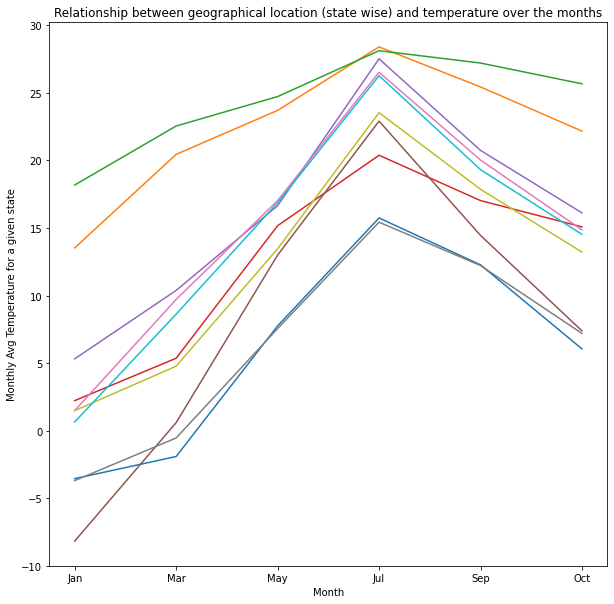

In [38]:
flt = pd.DataFrame(cord_to_temp.to_records())

# to avoid data clustering, we gather 50% states to plot
flt_sampled = flt.sample(frac=0.5, replace=False, random_state=1)

# we conduct filtering, removing the rows with more than 10 nans
indexes_to_keep = []
for index, row in enumerate(flt_sampled.iterrows()):
    if sum(row[1][1:].isna()) <= 10:
        indexes_to_keep.append(index)

# we still have 27 entries, so preserve the trend while not distorting the dataset too much
print(len(indexes_to_keep))

# filter
flt_sampled = flt_sampled[flt_sampled.index.isin(indexes_to_keep)]
flt_sampled = flt_sampled.set_index("state")

# we apply np.mean row-wise
flt_sampled = flt_sampled.apply(lambda row: row.fillna(row.mean()), axis=1)

flt_sampled = flt_sampled[["1", "3", "5", "7", "9", "10"]]


fig, ax = plt.subplots(1,1, figsize=(10,10))
for row in flt_sampled.iterrows():
    sns.lineplot(flt_sampled.columns.to_list(), row[1], ax=ax)

ax.set_xlabel("Month");
ax.set_ylabel("Monthly Avg Temperature for a given state");
ax.set_xticklabels(["Jan", "Mar", "May", "Jul", "Sep", "Oct"])
ax.set_title("Relationship between geographical location (state wise) and temperature over the months");

From the above curve, we see that there is indeed a trend between geographical location and the temperature variation over the seasons, this is evident because all lines follow a similar strcture while being shifted veritically. This makes sense, because the closer the region or that state gets near the equator, the hotter it gets over the seasons, but all locations in the US transition in the same pattern across seasons.

For the curious readers, we extracted the geographical coordinates in the above plot. One of the high curve represent Florida. One of the lower curve represent Washington. Now, we cross-validate the trend with the monthly temperature data provided by NOAA, and found that the results are consistent. So, even though we use a small random sample from the original dataset, we can still see the effect of geographical location to the temperature over the months, without overplotting the graph.

We now follow the same process to see if there's relationship between geographical location and precipitation.

In [39]:
#construct a pivot_table for precipitation
cord_to_prcp = daily_global_weather_US_final.pivot_table(index="state", columns="month", values="PRCP_Millimeter", aggfunc=np.mean)
cord_to_prcp.head()

month,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
Alabama,5.609333,8.962069,5.679355,5.471333,3.805806,4.382000,5.294194,4.101935,3.076000,0.871910
Alaska,1.191455,2.579754,1.299290,1.671118,1.084910,2.175736,2.478121,3.288181,4.039560,2.801391
Alberta,4.587097,2.628571,4.419355,2.093103,1.954839,6.013333,0.893548,0.000000,0.336667,5.540909
Arizona,0.636209,1.636769,3.266362,0.653984,0.169489,0.181020,1.301393,1.074499,0.230539,0.203667
Arkansas,4.346667,2.786207,4.716129,4.800000,5.735484,2.316667,2.403226,5.877419,4.573333,0.413636


27


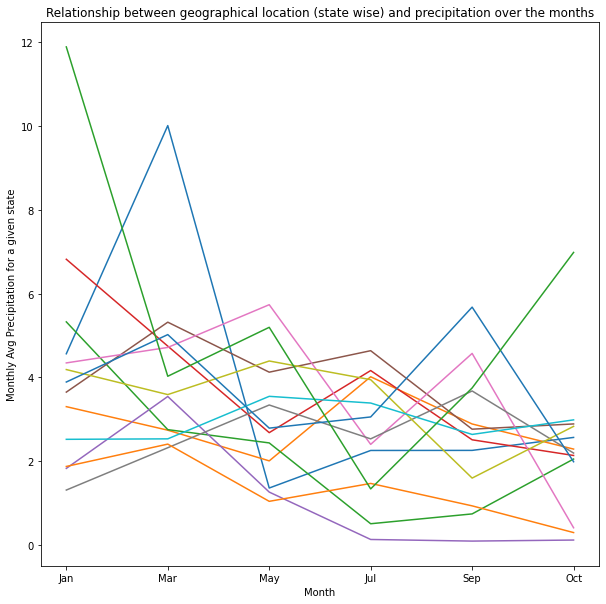

In [40]:
flt_prcp = pd.DataFrame(cord_to_prcp.to_records())

# to avoid data clustering, we gather well-known geographical locations
flt_prcp_sampled = flt_prcp.sample(frac=0.5, replace=False, random_state=3)

# we conduct filtering, removing the rows with more than 10 nans
indexes_to_keep = []
for index, row in enumerate(flt_prcp_sampled.iterrows()):
    if sum(row[1][1:].isna()) <= 10:
        indexes_to_keep.append(index)

# we still have 27 entries, so preserve the trend while not distorting the dataset too much
print(len(indexes_to_keep))

# filter
flt_prcp_sampled = flt_prcp_sampled[flt_prcp_sampled.index.isin(indexes_to_keep)]
flt_prcp_sampled = flt_prcp_sampled.set_index("state")

# we apply np.mean row-wise
flt_prcp_sampled = flt_prcp_sampled.apply(lambda row: row.fillna(row.mean()), axis=1)
flt_prcp_sampled = flt_prcp_sampled[["1", "3", "5", "7", "9", "10"]]

fig, ax = plt.subplots(1,1, figsize=(10,10))
for row in flt_prcp_sampled.iterrows():
    sns.lineplot(flt_prcp_sampled.columns.to_list(), row[1], ax=ax)

ax.set_xlabel("Month");
ax.set_ylabel("Monthly Avg Precipitation for a given state");
ax.set_xticklabels(["Jan", "Mar", "May", "Jul", "Sep", "Oct"])
ax.set_title("Relationship between geographical location (state wise) and precipitation over the months");

From the above curve, we see that the relationship between precipitation and geographical location (state wise) is less stiking as compared to the case for temperature. While large mountain ranges can influence preciptation patterns, we cannot use statistical methods to capture that piece of information using the existing dataset. Hence, what we get is more of a trend of precipitation across different locations in 2020.

So, the takeaway here is that we cannot compare the precipitation from one state to the other, or one geographical location vs. the other just by the geographical coordinates, as seen from the above graph that most of the precipitation exist in the target range (0-8). Granted, from the above plot we can kind of see a trend where certain months tend to be rainy for the majority of states, but we can not generalize this to compare one geographical location's precipitation to the other.

__Exploration 2: What months are within the rainy season? What months are typically dry? Does the discovery align with scientific explanantion? If we take a inspect the relationship in terms of weeks, would we find a oscillation pattern?__

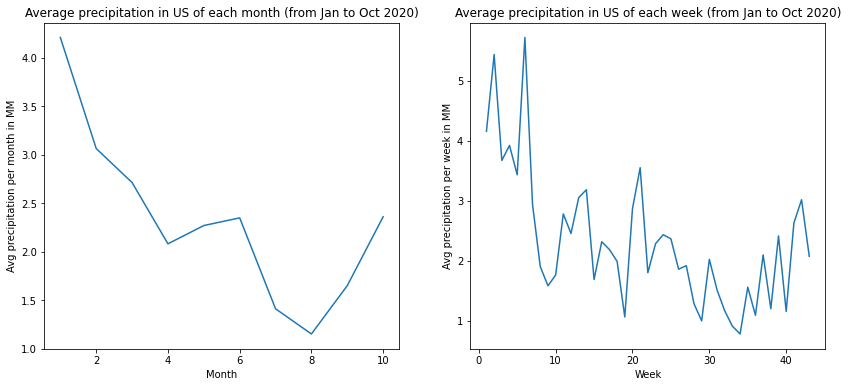

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

month_prcp_avg = daily_global_weather_US_final.groupby(["month"])["PRCP_Millimeter"].agg(np.mean)
axs[0].plot(month_prcp_avg);
axs[0].set_title("Average precipitation in US of each month (from Jan to Oct 2020)");
axs[0].set_xlabel("Month");
axs[0].set_ylabel("Avg precipitation per month in MM");

week_prcp_avg = daily_global_weather_US_final.groupby(["week"])["PRCP_Millimeter"].agg(np.mean)
axs[1].plot(week_prcp_avg);
axs[1].set_title("Average precipitation in US of each week (from Jan to Oct 2020)");
axs[1].set_xlabel("Week");
axs[1].set_ylabel("Avg precipitation per week in MM");

From the plot to the left, we see that the spring in 2020 on average has more precipitation than other seasons. This is backed by scientific explanation, when during spring, the best precipitation dynamics of winter and summer converge. Correspondingly, we expect to see the least rain near august, as that is often the hottest time over the year (with a lot of droughts). For winter, we expect to see less rain as compared to spring. However, because the dataset ends in Oct, we cannot fully validate this trend. However, based on the above graph, we can see there is a correlation between the month and the average precipitation of that month.

From the plot to the right, if we plot the weekly precipitation, we can see that we transition from a general trend to a more "oscilation" curve. This is expected, because in nature, we know many phenomonons oscillate with respect to time. This gives us an idea of the level of granularity to be used for the data to be fed into the model.

__Exploration 3: What months tend to be hot? What months tend to be cold? Does the discovery align with how the season transitions?__

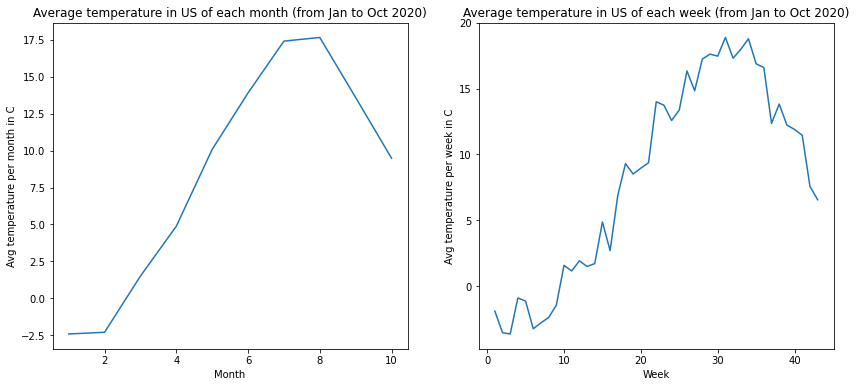

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

month_temp_avg = daily_global_weather_US_final.groupby(["month"])["TEMP_C"].agg(np.mean)
axs[0].plot(month_temp_avg);
axs[0].set_title("Average temperature in US of each month (from Jan to Oct 2020)");
axs[0].set_xlabel("Month");
axs[0].set_ylabel("Avg temperature per month in C");

week_temp_avg = daily_global_weather_US_final.groupby(["week"])["TEMP_C"].agg(np.mean)
axs[1].plot(week_temp_avg);
axs[1].set_title("Average temperature in US of each week (from Jan to Oct 2020)");
axs[1].set_xlabel("Week");
axs[1].set_ylabel("Avg temperature per week in C");

From the plot to the left, we can confidently say that there is a correlation between month and average temperature for that month. The graph shows that, as we transition from spring to summer, the temperature gradually increases, and stablizes for a month during the hottest month (July & Aug), and then starts to decline as we enter the fall season. Note that the dataset ends in Oct 2020, so we cannot visulize the winter season here. However, based on the above graph, we can see there is a correlation between the month and the average temperature. Based on how season transitions, we can infer temperature when we are given what month it is.

From the plot to the right, if we plot the weekly temperature, again we can see that we transition from a general trend to a more "oscilation" curve that still follows the monthly shape. This is expected, because in nature, temperature fluctuates up and down, while the transition of seasons ensure the general trend. This gives us an idea of the level of granularity to be used for the data to be fed into the model.

__Exploration 4: Is there a relationship between temperature and precipitation across the months?__

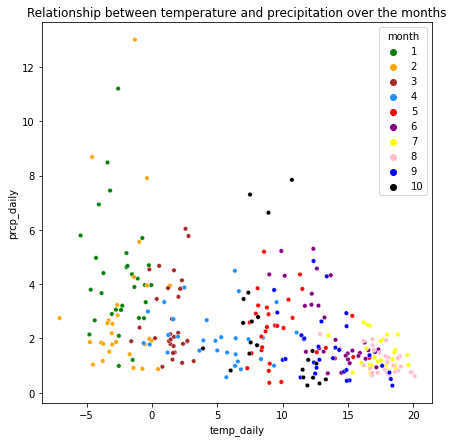

In [43]:
# construct a dataframe to contain the daily temperature and precipitation (avg across all stations that have data on that date)
res = pd.DataFrame()
res["prcp_daily"] = daily_global_weather_US_final.groupby(["month", "day"])["PRCP_Millimeter"].agg(np.mean)
res["temp_daily"] = daily_global_weather_US_final.groupby(["month", "day"])["TEMP_C"].agg(np.mean)
res["month"] = daily_global_weather_US_final.groupby(["month", "day"])["month"].first()

res.reset_index(drop=True, inplace=True)

# visualize
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(data=res, 
                x="temp_daily", 
                y="prcp_daily", 
                hue="month",
                s=20,
                palette=['green','orange','brown','dodgerblue','red', 'purple', 'yellow', 'pink', 'blue', 'black'],
                ax=ax);
ax.set_title("Relationship between temperature and precipitation over the months");

From the above scatter plot, we can see that there is a relationship between temperature and precipitation. Using the daily averaged temperature and precipitation through Jan 2020 to Oct 2020, we can se that as the temperature increases, the amount of precipitation tends to decrease. In Jan and Feb, when the temperature is cold, we tend to see larger precipitation more often. This trend fits neatly with the previously observed trend with respect to season, that in spring, we tend to see the most rainfall and near august, we tend to see the least (during july and august, we have the hottest days and we are less likely to see rains, and this is represented by the yellow and pink dots to the very right of the above graph). So, from this discovery, we can use temperature to infer the range of precipitation in the US region. If you bin the above scatter plot by temperature, we can see different distribution of preciptation (in spring it is spread apart in the vertical axis, and in July and August it is quite clustered near 1 in the vertical axis).

__Q: Is there any correlation between the variables you are interested in exploring?__

From the above analysis, we can see that:

- There is a relationship between geographical location and the average temperature over the months. Geographical locations that are near the equator tend to face higher temperatures than places that are further away form the equator.
- There is a relationship between the month and the average precipitation for that month. This is due to how season transitions and certain months are favorable for rains (hence called rainy months).
- There is a relationship between the month and the average temperature for that month. This again is due to how season transitions.
- There is a relationship between precipitation and temperature across the months. This is based on the previous discoveries, and the fact that, it is less likely to rain during continuous hot weather, and so we expect to see less precipitation in summer, in the US region.

From the above discoveries, we could summarize and say that, by collecting the month, precipitation, and geographical locations where the temperature measurement is conducted, we can build a model to predict the temperature, as both geographical location and month have relationships with temperature. Similarly, we can collect geographical location, month, and temperature to try predict the precipitation.

__Q: How would you cleanly and accurately visualize the relationship among variables?__

This question is answered as we walk through the above four explorations. Basically, several techniques are used to cleanly and accurately visualize the relationship.

Given that we care about the average temperature and precipitation across the month, we use averaging to allow the data to generalize and be more smooth. Then, to observe clean and clear trend, we use:

- proper data cleaning routine to remove outliers and fill in missing values through inference
- random sampling to avoid overplotting
- plot the average over the months instead of all data
- group data points that are near (geographically) into one group to allow the trend to generalize
- proper selction of graphing method and use proper color, and display size
- use of subplots to compare plots of different granularity on a certain topic

## Data Extraction

We extract the final dataset to be used in modeling.

In [44]:
daily_global_weather_US_final.to_pickle("../data/daily_weather_US_df.pk")

## References

[1] https://www.ncdc.noaa.gov/ghcn-daily-description

[2] https://en.wikipedia.org/wiki/U.S._state_and_territory_temperature_extremes

[3] https://latitudelongitude.org/us/

[4] https://weather.com/news/climate/news/extreme-rainfall-precipitation-recorded-50-states